In [34]:
import tensorflow as tf
import numpy as np
import pandas as pd
import json
import nltk
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, GlobalAveragePooling1D, Flatten, Bidirectional
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt

In [22]:
with open('artour.json') as artour:
  data = json.load(artour)

In [23]:
tags = []
inputs = []
outputs = {}
for intent in data['intents']:
  outputs[intent['tag']]=intent['output']
  for lines in intent['input']:
    inputs.append(lines)
    tags.append(intent['tag'])

In [24]:
my_data = pd.DataFrame({"inputs":inputs,
                      "tags":tags})

In [26]:
my_data.tail(30)

,inputs,tags
136,prosedur saat pandemi,covid
137,protokol kesehatan prambanan,covid
138,protokol pandemi,covid
139,sejarah berdirinya Candi Prambanan?,sejarah
140,sejarah,sejarah
141,Kisah Ramayana?,sejarah
142,Dewi Shinta Ramayana,sejarah
143,Rama Shinta,sejarah
144,Sejarah Candi Prambanan?,sejarah
145,Roro Jonggrang,sejarah


# Preprocessing Data

In [28]:
import string
my_data['inputs'] = my_data['inputs'].apply(lambda the_word:[x.lower() for x in the_word if x not in string.punctuation])
my_data['inputs'] = my_data['inputs'].apply(lambda the_word: ''.join(the_word))
my_data.tail(30)

,inputs,tags
136,prosedur saat pandemi,covid
137,protokol kesehatan prambanan,covid
138,protokol pandemi,covid
139,sejarah berdirinya candi prambanan,sejarah
140,sejarah,sejarah
141,kisah ramayana,sejarah
142,dewi shinta ramayana,sejarah
143,rama shinta,sejarah
144,sejarah candi prambanan,sejarah
145,roro jonggrang,sejarah


In [29]:
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory

factory = StemmerFactory()
stemmer = factory.create_stemmer()

for i, kalimat in enumerate (my_data['inputs']):
    my_data['inputs'][i] = stemmer.stem(kalimat)

my_data.tail(30)

,inputs,tags
136,prosedur saat pandemi,covid
137,protokol sehat prambanan,covid
138,protokol pandemi,covid
139,sejarah diri candi prambanan,sejarah
140,sejarah,sejarah
141,kisah ramayana,sejarah
142,dewi shinta ramayana,sejarah
143,rama shinta,sejarah
144,sejarah candi prambanan,sejarah
145,roro jonggrang,sejarah


In [30]:
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory

factory = StopWordRemoverFactory()
stopword = factory.create_stop_word_remover()

for i, kalimat in enumerate (my_data['inputs']):
    my_data['inputs'][i] = stopword.remove(kalimat)

my_data.tail(30)

,inputs,tags
136,prosedur pandemi,covid
137,protokol sehat prambanan,covid
138,protokol pandemi,covid
139,sejarah diri candi prambanan,sejarah
140,sejarah,sejarah
141,kisah ramayana,sejarah
142,dewi shinta ramayana,sejarah
143,rama shinta,sejarah
144,sejarah candi prambanan,sejarah
145,roro jonggrang,sejarah


In [31]:
tokenizer = Tokenizer(num_words=2000)
tokenizer.fit_on_texts(my_data['inputs'])
train = tokenizer.texts_to_sequences(my_data['inputs'])

from tensorflow.keras.preprocessing.sequence import pad_sequences
x_train = pad_sequences(train)

from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_train = le.fit_transform(my_data['tags'])

In [32]:
input_shape = x_train.shape[1]
print(input_shape)

6


In [33]:
vocabulary = len(tokenizer.word_index)
print("number of unique words : ", vocabulary)
output_length = le.classes_.shape[0]
print("output length: ", output_length)

number of unique words :  124
output length:  20


# Modelling Data

In [35]:
i = Input(shape=(input_shape,))
x = Embedding(vocabulary+1,10)(i)
x = Bidirectional(LSTM(10, return_sequences=True))(x)
x = Flatten()(x)
x = Dense(output_length, activation="softmax")(x)
model = Model(i,x)

In [36]:
from tensorflow.keras.optimizers import Adam
model.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(learning_rate=0.0005), metrics=['accuracy'])

In [37]:
train = model.fit(x_train, y_train, epochs=250)

Epoch 1/250
6/6 [==============================] - 7s 17ms/step - loss: 2.9960 - accuracy: 0.0361
Epoch 2/250
6/6 [==============================] - 0s 6ms/step - loss: 2.9940 - accuracy: 0.0542
Epoch 3/250
6/6 [==============================] - 0s 7ms/step - loss: 2.9923 - accuracy: 0.0964
Epoch 4/250
6/6 [==============================] - 0s 9ms/step - loss: 2.9906 - accuracy: 0.1325
Epoch 5/250
6/6 [==============================] - 0s 8ms/step - loss: 2.9891 - accuracy: 0.1566
Epoch 6/250
6/6 [==============================] - 0s 8ms/step - loss: 2.9874 - accuracy: 0.1627
Epoch 7/250
6/6 [==============================] - 0s 16ms/step - loss: 2.9855 - accuracy: 0.1687
Epoch 8/250
6/6 [==============================] - 0s 8ms/step - loss: 2.9837 - accuracy: 0.1867
Epoch 9/250
6/6 [==============================] - 0s 11ms/step - loss: 2.9817 - accuracy: 0.1928
Epoch 10/250
6/6 [==============================] - 0s 11ms/step - loss: 2.9797 - accuracy: 0.1687
Epoch 11/250
6/6 [=======

# Visualize Training

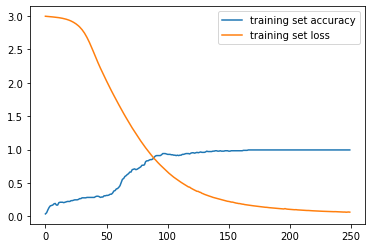

In [38]:
plt.plot(train.history['accuracy'], label='training set accuracy')
plt.plot(train.history['loss'], label='training set loss')
plt.legend()

# Save Model

In [39]:
save_model = "ArtourV3_Bidirectional_LSTM"
tf.saved_model.save(model, save_model)


FOR DEVS: If you are overwriting _tracking_metadata in your class, this property has been used to save metadata in the SavedModel. The metadta field will be deprecated soon, so please move the metadata to a different file.



FOR DEVS: If you are overwriting _tracking_metadata in your class, this property has been used to save metadata in the SavedModel. The metadta field will be deprecated soon, so please move the metadata to a different file.


INFO:tensorflow:Assets written to: ArtourV3_Bidirectional_LSTM\assets


INFO:tensorflow:Assets written to: ArtourV3_Bidirectional_LSTM\assets


In [40]:
model.save("artour_v3.h5")

# Inference Code

In [42]:
import random
print("ARTour : Selamat Datang ARTourist!")

while True:
  texts_p = []
  prediction_input = input('You : ')
  #if prediction_input == 'keluar':
  #  print("ARTour : Terima kasih telah berkunjung :D, selamat menikmati liburan Anda~")
  #  break
  prediction_input = [letters.lower() for letters in prediction_input if letters not in string.punctuation]
  prediction_input = ''.join(prediction_input)

  #from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
  #factory = StemmerFactory()
  #stemmer = factory.create_stemmer()
  #prediction_input = [stemmer.stem(x) for x in prediction_input]
  #prediction_input = ''.join(prediction_input)

  #from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
  #factory = StopWordRemoverFactory()
  #stopword = factory.create_stop_word_remover()
  #prediction_input = [stopword.remove(x) for x in prediction_input]
  #prediction_input = ''.join(prediction_input)

  texts_p.append(prediction_input)
  
  prediction_input = tokenizer.texts_to_sequences(texts_p)
  prediction_input = np.array(prediction_input).reshape(-1)
  prediction_input = pad_sequences([prediction_input], input_shape)

  output = model.predict(prediction_input)
  output = output.argmax()

  response_tag = le.inverse_transform([output])[0]
  print("ARTour : ", random.choice(outputs[response_tag]))
  #if response_tag < 0.5:
  #  print("ARTour : Maaf, bisa diulang pertanyaannya?")
  #  continue
  if response_tag == 'keluar':
    break

ARTour : Selamat Datang ARTourist!
ARTour :  Hai ARTourist!
ARTour :  Hari ini ARTour sangat senang :D
ARTour :  Namaku ARTour, salam kenal ya!
ARTour :  Jam buka candi mulai pukul 06.00-17.00 WIB
ARTour :  Jam buka candi mulai pukul 06.00-17.00 WIB
ARTour :  Lokasi Candi Prambanan : Jl. Raya Solo - Yogyakarta No.16, Kranggan, Bokoharjo, Kec. Prambanan, Kabupaten Sleman, Daerah Istimewa Yogyakarta 55571
ARTour :  Mulai dari gantungan kunci, miniatur candi Hindu hingga beragam benda unik lainnya khas Prambanan bisa Anda dapatkan di tempat jual beli oleh-oleh Candi Prambanan.
ARTour :  Pawon Prambanan cocok dikunjungi untuk rombongan, baik keluarga atau perusahan. Tempatnya yang luas akan membuatmu nyaman dan betah berlama-lama di sana. Pawon Prambanan beralamat di Jalan Candi Sewu Nomor 24, Nngangrukbaru, Timur Candi, Kecamatan Prambanan, Kabupaten Klaten, Jawa Tengah. Jam operasional pukul 07.00-20.00 WIB.
ARTour :  Menuju Prambanan menggunakan kendaraan pribadi tidaklah sulit. Cukup m